In [1]:
#!pip install pandoc
#!pip install nbconvert

In [2]:
#!pip3 install mjoindices

In [3]:
#!pip install -U notebook-as-pdf
#!pyppeteer-install

In [4]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
import netCDF4 as nc
from scipy import stats
from scipy import signal
from scipy.fft import fft 
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import time

/tmp/ipykernel_4144/2652616351.py:5: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [6]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [7]:
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.linewidth':2}
plt.rcParams.update(parameters)

In [8]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [9]:
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #les données saisies dans Data doivent avoir 
    #la dimension n1=espace, n2=temps on initialise les matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #pour chaque point de l'espace on fait la corrélation
        #de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb a deux sorties : la première est exécutée 
        #et la seconde est p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #On génère une variable qui fait que seules les valeurs de Cor ou la corrélation
    # est significative sont affichées
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #Nous générons la carte de régression par multiplication matricielle. 
    #Attention aux dimensions !
    reg=Data.dot(Index)/ (n2-1)
    #de même, on fait un masque pour que la carte de régression ne 
    #s'affiche que lorsqu'elle est significative
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig


In [10]:
fname = '/home/wester/Desktop/SST/wind/ERA5_wind850_daymean_grid_MAMJJASON_1982-2019.nc'
ds = xr.open_dataset(fname)
lon = ds['lon']-180
lat = ds['lat']
u850=ds['u'].data

In [11]:
def main():
    # window length for filters
    window = 50

    # construct 10 days and 30 days low pass filters
    hfw = low_pass_weights(window, 1. / 10.)
    lfw = low_pass_weights(window, 1. / 90.)
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low = xr.DataArray(lfw, dims = ['window'])

    # Load the hourly 850hPa vorticity
    fname = '/home/wester/Desktop/SST/wind/ERA5_wind850_daymean_grid_MAMJJASON_1982-2019.nc'
    ds = xr.open_dataset(fname)
    hourly_data = ds.sel(time=slice("1982-03-01T00:00:00","2019-11-30T00:00:00"))['u']

    # Since the EAR5 data are hourly, we first average them into daily data.
    daily_data = hourly_data.resample(time='24h').mean(dim = 'time')
    #daily_data = hourly_data

    # apply the filters using the rolling method with the weights
    lowpass_hf = daily_data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = daily_data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf
    dvar = xr.DataArray.var(bandpass, dim = 'time', skipna = True)
    

    return lowpass_lf, bandpass, daily_data, dvar
if __name__ == '__main__':
    lowpass, passeband, data, indix  = main()

In [12]:
data_reel=data-lowpass

In [13]:
mov_average= data_reel.rolling(time = 30).mean()

In [14]:
data_60d=data_reel-mov_average

In [15]:
new_weekly = data_60d.resample(time='7D').mean(dim = 'time')

In [16]:
new_weekly.to_netcdf('/home/wester/Desktop/SST/wind/index_10_60d_u850_weekly.nc')

In [11]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
lon1 = ds['longitude']
lat1 = ds['latitude']
time1 = ds['time']
Rainf = ds['__xarray_dataarray_variable__']
Rain = ds['__xarray_dataarray_variable__'].data

In [12]:
Rain.shape

(662, 100, 140)

In [13]:
# Convertir les dates en numpy arrays pour comparer
time1_values = time1.values

In [14]:
fname = '/home/wester/Desktop/SST/wind/index_10_60d_u850_weekly.nc'
ds1 = xr.open_dataset(fname)
lon = ds1['lon']
lat = ds1['lat']
u850_d0 = ds1.sel(time=time1_values)
u850_d0.to_netcdf('/home/wester/Desktop/SST/wind/index_10_60d_u850_weekly_JJAS.nc')
u850_0d = u850_d0['__xarray_dataarray_variable__'].data

In [15]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag7 = time1 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
u850_d7 = ds1.sel(time=time1_lag7)
u850_d7.to_netcdf('/home/wester/Desktop/SST/wind/u850_7days.nc')
u850_7d = u850_d7['__xarray_dataarray_variable__'].data

In [16]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag14 = time1_lag7 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
u850_d14 = ds1.sel(time=time1_lag14)
u850_d14.to_netcdf('/home/wester/Desktop/SST/wind/u850_14days.nc')
u850_14d = u850_d14['__xarray_dataarray_variable__'].data

In [17]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag21 = time1_lag14 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
u850_d21 = ds1.sel(time=time1_lag21)
u850_d21.to_netcdf('/home/wester/Desktop/SST/wind/u850_21days.nc')
u850_21d = u850_d21['__xarray_dataarray_variable__'].data

In [18]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag28 = time1_lag21 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
u850_d28 = ds1.sel(time=time1_lag28)
u850_d28.to_netcdf('/home/wester/Desktop/SST/wind/u850_28days.nc')
u850_28d = u850_d28['__xarray_dataarray_variable__'].data

In [19]:
# Extraire les dates du premier fichier et appliquer un décalage de -7 jours
time1_lag35 = time1_lag28 - pd.Timedelta(days=7)
# Filtrer le fichier 2 pour obtenir les valeurs à ces nouvelles dates décalées
u850_d35 = ds1.sel(time=time1_lag35)
u850_d35.to_netcdf('/home/wester/Desktop/SST/wind/u850_35days.nc')
u850_35d = u850_d35['__xarray_dataarray_variable__'].data

In [20]:
Rain_index=np.nanmean(np.reshape(Rain,(662,len(lat1)*len(lon1))),1)
u850_0days=np.nan_to_num(np.reshape(u850_0d,(662,len(lat)*len(lon))))
u850_7days=np.nan_to_num(np.reshape(u850_7d,(662,len(lat)*len(lon))))
u850_14days=np.nan_to_num(np.reshape(u850_14d,(662,len(lat)*len(lon))))
u850_21days=np.nan_to_num(np.reshape(u850_21d,(662,len(lat)*len(lon))))
u850_28days=np.nan_to_num(np.reshape(u850_28d,(662,len(lat)*len(lon))))
u850_35days=np.nan_to_num(np.reshape(u850_35d,(662,len(lat)*len(lon))))

In [21]:
Index_rain_SNG=np.transpose(Rain_index)
u850_0_days=np.transpose(u850_0days)
u850_7_days=np.transpose(u850_7days)
u850_14_days=np.transpose(u850_14days)
u850_21_days=np.transpose(u850_21days)
u850_28_days=np.transpose(u850_28days)
u850_35_days=np.transpose(u850_35days)

In [22]:
u850_0_days.shape

(10512, 662)

In [23]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.feature as cfeat
import numpy.ma as ma
import time
import pandas as pd
from netCDF4 import Dataset
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#statistics
from scipy import signal,stats
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_4144/4163732201.py:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [24]:
import xarray as xr
import pandas as pd
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

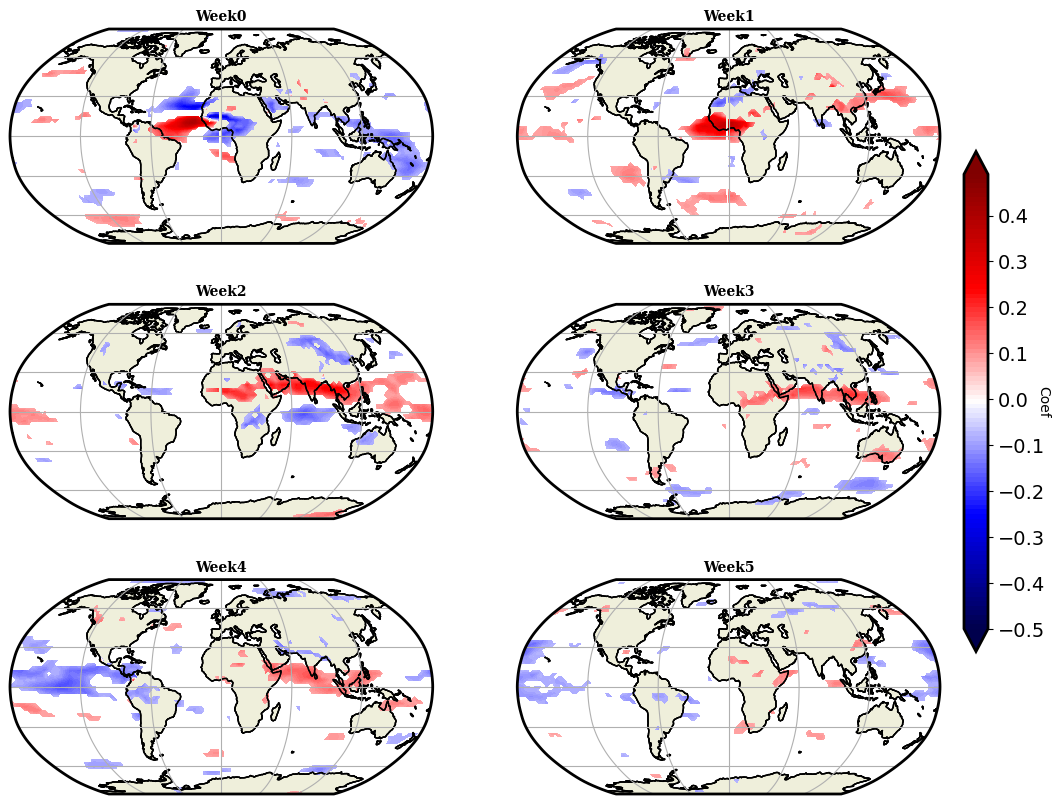

In [31]:
# Define the caracteristics of the plot
f = plt.figure(figsize=(12,10))                                                   # create a figure and define its size
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.2,wspace=0.2)               # adjust the space between subplots
axs = []
for i in range(6) :
    ax = f.add_subplot(3,2,i+1,projection=ccrs.Robinson(0))                      # the figure will be composed of 3x3 maps
    ax.coastlines()                                                                # add the coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree())#, draw_labels=True)                    # add the longitude / latitude lines
    #gl.right_labels = False                                                        # remove latitude labels on the right
    #gl.top_labels = False                                                          # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                         # add land mask
    axs.append(ax)
month = ['Week0','Week1','Week2','Week3','Week4','Week5']
step_arrows = [u850_0_days,u850_7_days,u850_14_days,u850_21_days,u850_28_days,u850_35_days]
#step_arrows = [delai_0days_WA, delai_7days_WA, delai_14days_WA, delai_21days_WA, delai_28days_WA]
for i in range(len(step_arrows)):
    date = step_arrows[i]    
    #date = start_date + i
    [correD,pvalueD,csig,reg,reg_sig]=IndexRegression(date,Index_rain_SNG[:],0.05)
    #precip = np.squeeze(pre_all[i,:,:])
    axs[i].set_global()
    im = axs[i].contourf(lon,lat,csig.reshape(len(lat),len(lon)),cmap='seismic',levels=np.arange(-0.5,0.5,0.01), extend='both',transform = ccrs.PlateCarree())
    # add the date in the map titles 
    #axs[i].set_title(np.datetime_as_string(date,unit='m'))
    axs[i].set_title(month[i],fontsize=10, weight='bold',family = 'serif')
    axs[i].coastlines()
    #axs[i].add_feature(cfeat.COASTLINE,edgecolor = 'k')
    #axs[i].add_feature(cfeat.BORDERS, linestyle='-',alpha=1)#Ajouter dans les shapefiles des pays

# Add the titles and legend
#f.suptitle('Figure 1 distribution spatiale des précipitations en juin, juillet, août et septembre en AO sur la période 1981 à 2018',fontsize=14, weight='bold',family = 'serif',y=0.08)                 # add a title to the figure
#axs.set_title('csig_u850_rain_22_Aout',fontsize=18,weight='bold')
cbar_ax = f.add_axes([0.92, 0.25, 0.02, 0.5])                                       # define the colorbar location
cbar =f.colorbar(im,cax=cbar_ax)                                                   # display the colorbar

# Ajouter une barre de couleur en bas, horizontalement
#cbar_ax = f.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
#cbar = f.colorbar(im, cax=cbar_ax, orientation='horizontal')

cbar.set_label('Coef', rotation=270,fontsize=10)                             # add the title of the colorbar
# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_u850_Anom_rain_hebdomadaire.png', bbox_inches='tight')
plt.show()

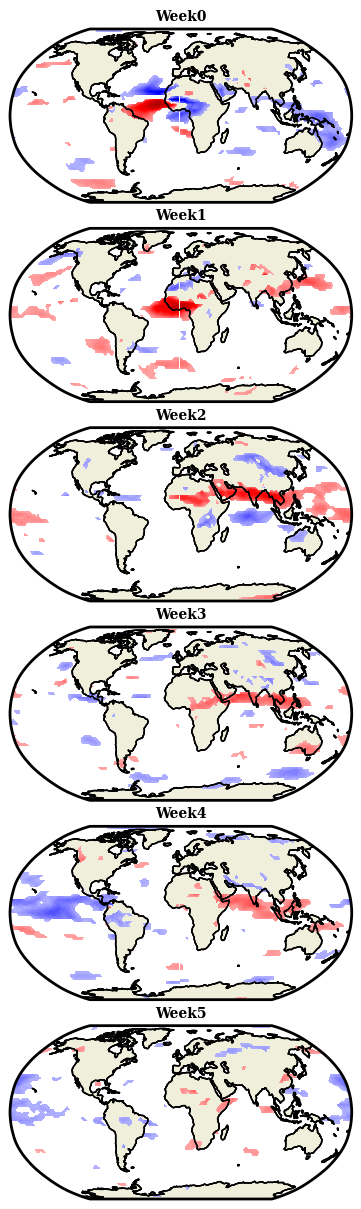

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the characteristics of the plot
f = plt.figure(figsize=(8, 15))  # define figure size for a single column layout
f.subplots_adjust(right=0.85, bottom=0.1, hspace=0.15)  # adjust space between subplots

axs = []
for i in range(6):
    ax = f.add_subplot(6, 1, i + 1, projection=ccrs.Robinson(0))  # 6 rows, 1 column
    ax.coastlines()  # add coastlines
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)  # add lat/lon gridlines
    #gl.right_labels = False  # remove latitude labels on the right
    #gl.top_labels = False  # remove longitude labels on the top
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')  # add land mask
    axs.append(ax)

# Set the titles and data for each subplot
month = ['Week0', 'Week1', 'Week2', 'Week3', 'Week4', 'Week5']
step_arrows = [u850_0_days,u850_7_days,u850_14_days,u850_21_days,u850_28_days,u850_35_days]
for i in range(len(step_arrows)):
    date = step_arrows[i]
    correD, pvalueD, csig, reg, reg_sig = IndexRegression(date, Index_rain_SNG[:], 0.05)
    axs[i].set_global()
    im = axs[i].contourf(lon, lat, csig.reshape(len(lat), len(lon)), cmap='seismic', levels=np.arange(-0.5, 0.5, 0.01), extend='both', transform=ccrs.PlateCarree())
    axs[i].set_title(month[i], fontsize=10, weight='bold', family='serif')
    axs[i].coastlines()
# Save figure
plt.savefig('/home/wester/Desktop/SST/ERA5/csig_ISO_u850_Anom_rain_hebdomadaire_colonnes.png', bbox_inches='tight')
plt.show()

In [25]:
def covariance(x, y):
    [n1,n2]=x.shape
    Cov=ma.empty([n1,])
    for nn in range(n1):
        xx = x[nn,:]-np.nanmean(x[nn,:])
        yy = y-np.nanmean(y)
        zz = 1/float(len(x[nn,:]))
        cov=zz*np.sum(xx*yy)
        Cov[nn]=cov
    return Cov

In [26]:
def somme(x, y):
    [n1,n2]=y.shape
    Summ=ma.empty([n2,])
    for nn in range(n2):
        som=np.sum(x*y[:,nn])
        Summ[nn]=som
    return Summ

In [27]:
#[correD,pvalueD,csig,reg,reg_sig]=IndexRegression(u850_0_days,Index_rain_SNG[:],0.05)
#delai_0days=csig
Cov_0days=covariance(u850_0_days,Index_rain_SNG)
preduct_0d=somme(Cov_0days,u850_0_days)

In [28]:
Cov_7days=covariance(u850_7_days,Index_rain_SNG)
preduct_7d=somme(Cov_7days,u850_7_days)

In [29]:
Cov_14days=covariance(u850_14_days,Index_rain_SNG)
preduct_14d=somme(Cov_14days,u850_14_days)

In [30]:
Cov_21days=covariance(u850_21_days,Index_rain_SNG)
preduct_21d=somme(Cov_21days,u850_21_days)

In [31]:
Cov_28days=covariance(u850_28_days,Index_rain_SNG)
preduct_28d=somme(Cov_28days,u850_28_days)

In [32]:
Cov_35days=covariance(u850_35_days,Index_rain_SNG)
preduct_35d=somme(Cov_35days,u850_35_days)

In [33]:
weekly_u850_0d=np.array(preduct_0d)
weekly_u850_7d=np.array(preduct_7d)
weekly_u850_14d=np.array(preduct_14d)
weekly_u850_21d=np.array(preduct_21d)
weekly_u850_28d=np.array(preduct_28d)
weekly_u850_35d=np.array(preduct_35d)

In [34]:
np.save('/home/wester/Desktop/SST/wind/preduct_0d_weekly_u850.npy',weekly_u850_0d)
np.save('/home/wester/Desktop/SST/wind/preduct_7d_weekly_u850.npy',weekly_u850_7d)
np.save('/home/wester/Desktop/SST/wind/preduct_14d_weekly_u850.npy',weekly_u850_14d)
np.save('/home/wester/Desktop/SST/wind/preduct_21d_weekly_u850.npy',weekly_u850_21d)
np.save('/home/wester/Desktop/SST/wind/preduct_28d_weekly_u850.npy',weekly_u850_28d)
np.save('/home/wester/Desktop/SST/wind/preduct_35d_weekly_u850.npy',weekly_u850_35d)

# Création des modéles de Machine Learning

In [35]:
u850_0d=np.load('/home/wester/Desktop/SST/wind/preduct_0d_weekly_u850.npy')
u850_7d=np.load('/home/wester/Desktop/SST/wind/preduct_7d_weekly_u850.npy')
u850_14d=np.load('/home/wester/Desktop/SST/wind/preduct_14d_weekly_u850.npy')
u850_21d=np.load('/home/wester/Desktop/SST/wind/preduct_21d_weekly_u850.npy')
u850_28d=np.load('/home/wester/Desktop/SST/wind/preduct_28d_weekly_u850.npy')
u850_35d=np.load('/home/wester/Desktop/SST/wind/preduct_35d_weekly_u850.npy')

In [36]:
U850_0da=np.reshape(u850_0d,[1,662])
U850_7da=np.reshape(u850_7d,[1,662])
U850_14da=np.reshape(u850_14d,[1,662])
U850_21da=np.reshape(u850_21d,[1,662])
U850_28da=np.reshape(u850_28d,[1,662])
U850_35da=np.reshape(u850_35d,[1,662])

In [37]:
U850_0da.shape

(1, 662)

In [38]:
fname = '/home/wester/Desktop/SST/index_10_60d_rainfall_weekly_JJAS_1982-2019.nc'
ds = xr.open_dataset(fname)
Rain = ds['__xarray_dataarray_variable__'].data
Rain.shape

(662, 100, 140)

In [39]:
index_10_60d=np.reshape(Rain,[662,100*140])

In [40]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

**Dans cette étude**, les signaux ISO des champs atmosphériques et de l'anomalie de précipitaton sont normalisés en utilisant la méthode de **(Yeo et Johnson, 2000)**.

Le calcul des **signaux ISO** a généré des données comprenant à la fois des valeurs positives et négatives. C'est pourquoi nous avons choisi **la transformation de Yeo-Johnson**, qui permet de prendre en compte les valeurs négatives présentes dans les données.


**Dans les modèles de machine learning**, on peut souvent être amené à transformer les variables pour avoir des distributions normales.

# La transformation de Yeo-Johnson

La transformation de Yeo-Johnson est une technique similaire à la transformation de Box-Cox, mais elle **peut être utilisée pour des distributions non normales et avec des valeurs négatives**. Yeo-Johnson **applique une transformation qui est une combinaison de la transformation de puissance et de la transformation logarithmique**. Comme pour Box-Cox, l'algorithme choisit automatiquement la transformation optimale pour maximiser la vraisemblance.

La formule de la transformation de Yeo-Johnson est la suivante :

$$
y(\lambda) =
\begin{cases}
\frac{(y+1)^\lambda - 1}{\lambda} & \text{si } y \geq 0, \lambda \neq 0 \\
\log(y+1) & \text{si } y \geq 0, \lambda = 0 \\
-\frac{(-y+1)^{2-\lambda}-1}{2-\lambda} & \text{si } y < 0, \lambda \neq 2 \\
-\log(-y+1) & \text{si } y < 0, \lambda = 2
\end{cases}
$$

où y est la variable à transformer et lambda est la valeur qui maximise la vraisemblance.

### Avantages de la transformation de Yeo-Johnson

- Peut être utilisée pour des distributions non normales et avec des valeurs négatives.
- Comme pour Box-Cox, la valeur optimale de lambda est choisie automatiquement pour maximiser la vraisemblance.

### Inconvénients de la transformation de Yeo-Johnson

- Peut être plus lente à calculer que la transformation de Box-Cox.
- La transformation peut être instable pour certaines valeurs de lambda.

In [41]:
from sklearn.preprocessing import PowerTransformer
# Initialiser un objet PowerTransformer avec la méthode de Yeo-Johnson
yeo_johnson = PowerTransformer(method='yeo-johnson')

In [42]:
Rain_Index=yeo_johnson.fit_transform(index_10_60d)

In [43]:
Rain_Index.shape

(662, 14000)

In [44]:
aa0=np.transpose(U850_0da)
aa7=np.transpose(U850_7da)
aa14=np.transpose(U850_14da)
aa21=np.transpose(U850_21da)
aa28=np.transpose(U850_28da)
aa35=np.transpose(U850_35da)

In [45]:
aa35.shape

(662, 1)

In [46]:
delai_0days= yeo_johnson.fit_transform(aa0)
delai_7days= yeo_johnson.fit_transform(aa7)
delai_14days= yeo_johnson.fit_transform(aa14)
delai_21days= yeo_johnson.fit_transform(aa21)
delai_28days= yeo_johnson.fit_transform(aa28)
delai_35days= yeo_johnson.fit_transform(aa35)

In [47]:
lead_time=[delai_0days,delai_7days,delai_14days,delai_21days,delai_28days,delai_35days]

In [48]:
rain_Index=np.squeeze(yeo_johnson.fit_transform(np.reshape(Index_rain_SNG,[662,1])))

In [49]:
rain_Index.shape

(662,)

In [50]:
Rain_Index[np.isnan(Rain_Index)] = 0

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [52]:
# Fonction pour calculer le coefficient de corrélation avec gestion des NaN
def correlation_coefficient(y_true, y_pred):
    if np.var(y_true) == 0 or np.var(y_pred) == 0:
        return 0  # Si la variance est nulle, la corrélation est 0
    else:
        return pearsonr(y_true, y_pred)[0]

In [53]:
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
n_jobs = -1
# Nombre total de semaines (662) et les 17 semaines de validation par an
total_weeks = 662
weeks_per_year = 17
n_splits = total_weeks // weeks_per_year  # Le nombre de splits

# Créer un split de validation croisée en série temporelle
ts_cv = TimeSeriesSplit(n_splits=n_splits)
# Définition des scores à utiliser pour la validation croisée
scoring_mae = make_scorer(mean_absolute_error)
scoring_corr = make_scorer(correlation_coefficient)
n_jobs = -1

# Modèle Adaboost

In [54]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

In [55]:
# Initialisation de l'objet AdaBoost Regressor
Reg_AB = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5))

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [100, 200, 300, 400],                    # Nombre d'estimateurs
    'learning_rate': [0.01, 0.1, 0.5, 1.0]              # Taux d'apprentissage
}

# Définition du score pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_AB, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les résultats
S2S_AB = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_Adaboost_1982-2019.npy', S2S_AB)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35daysAdaboost_1982-2019..npy', S2S_corr)

Mean MAE for 0days (best model): 0.8050496013611155
Mean Correlation for 0days: 0.2112256698664384
Mean MAE for 7days (best model): 0.7921597470813599
Mean Correlation for 7days: 0.22912915528324393
Mean MAE for 14days (best model): 0.7906000018784161
Mean Correlation for 14days: 0.26765276975613134
Mean MAE for 21days (best model): 0.7918563700374373
Mean Correlation for 21days: 0.260593045668649
Mean MAE for 28days (best model): 0.7916768230865706
Mean Correlation for 28days: 0.18973366329583172
Mean MAE for 35days (best model): 0.8059305680372301
Mean Correlation for 35days: 0.25573553114721426


# La régression Ridge

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [73]:
from sklearn.linear_model import Ridge
# Création d'un objet Ridge Regression
Reg_R = Ridge()

# Paramètres à tester pour la recherche de grille
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et obtenir les scores
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Recherche de grille et validation croisée en une étape
    grid_search = GridSearchCV(Reg_R, param_grid=param_grid, cv=ts_cv, n_jobs=n_jobs, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle trouvé par GridSearchCV pour ce délai
    best_model = grid_search.best_estimator_
    
    # Obtenir les scores avec cross_val_score en utilisant le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(mean_absolute_error))
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    
    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    #print(f'Best alpha for {name}:', grid_search.best_params_['alpha'])
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_Ridge.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35days_Ridge.npy', S2S_corr)

Mean MAE for 0days: 0.7375333599555577
Mean Correlation for 0days: 0.35458048859542357
Mean MAE for 7days: 0.7277541651287297
Mean Correlation for 7days: 0.3535796359866872
Mean MAE for 14days: 0.7296430523798767
Mean Correlation for 14days: 0.4117178919058469
Mean MAE for 21days: 0.7372835494666505
Mean Correlation for 21days: 0.3508823240438684
Mean MAE for 28days: 0.7314974821330577
Mean Correlation for 28days: 0.34987315294798277
Mean MAE for 35days: 0.7418643656686866
Mean Correlation for 35days: 0.3497627648098123


# Modèle de régression Linéaire

In [74]:
import netCDF4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

In [75]:
# Création d'un objet Linear Regression
Reg_LR = LinearRegression()

# Définition du score à utiliser pour la validation croisée
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []
# Boucle sur chaque délai pour effectuer la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer la validation croisée
    scores = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring)
    
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    scores_corr = cross_val_score(Reg_LR, delai, rain_Index, cv=ts_cv, scoring=scoring_corr)
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name}:', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_RL.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35days_RL.npy', S2S_corr)

Mean MAE for 0days: 0.7375332919967978
Mean Correlation for 0days: 0.35458048859542357
Mean MAE for 7days: 0.7277540953583226
Mean Correlation for 7days: 0.3535796359866871
Mean MAE for 14days: 0.7296429717106361
Mean Correlation for 14days: 0.4117178919058469
Mean MAE for 21days: 0.7372834810530833
Mean Correlation for 21days: 0.3508823240438684
Mean MAE for 28days: 0.731497434579223
Mean Correlation for 28days: 0.3498731529479829
Mean MAE for 35days: 0.7418643271216155
Mean Correlation for 35days: 0.3497627648098123


# Support-vector-regression

In [76]:
from sklearn.svm import SVR
# Création d'un objet SVR
Reg_SVR = SVR()

# Définition des paramètres à tester pour la recherche de grille
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Définition du score à utiliser pour la recherche de grille
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_SVR, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)
    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_SVR.npy', S2S)
# Sauvegarder les coefficients de corrélation dans un fichier .npy
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35days_SVR.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7639954206439988
Mean Correlation for 0days: 0.3004420977690166
Mean MAE for 7days (best model): 0.7458719913065555
Mean Correlation for 7days: 0.3074587133636513
Mean MAE for 14days (best model): 0.7555693994554169
Mean Correlation for 14days: 0.3241928018787076
Mean MAE for 21days (best model): 0.7642060902065673
Mean Correlation for 21days: 0.2756478139808335
Mean MAE for 28days (best model): 0.7431619842436417
Mean Correlation for 28days: 0.31823964389670184
Mean MAE for 35days (best model): 0.7746826503143728
Mean Correlation for 35days: 0.2809332078900534


# Random Forest avec GridSearchCV

In [77]:
from sklearn.ensemble import RandomForestRegressor
# Définition de l'objet Random Forest Regressor
Reg_RF = RandomForestRegressor()

# Paramètres pour la recherche de grille
param_grid = {
    'n_estimators': [50, 100, 200],      # Nombre d'arbres dans la forêt
    'max_depth': [10, 20, None],         # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],     # Minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]        # Minimum d'échantillons dans chaque feuille
}

# Définition du score à utiliser pour l'évaluation
scoring = make_scorer(mean_absolute_error)

# Initialisation de la liste pour les scores moyens pour chaque délai
mean_scores_mae = []
mean_scores_corr = []
# Boucle pour chaque délai avec recherche de grille et validation croisée
for delai, name in zip(delais, delai_names):
    grid_search = GridSearchCV(Reg_RF, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    best_model = grid_search.best_estimator_

    # Calculer les scores MAE avec validation croisée pour le meilleur modèle
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)
    
# Sauvegarder les résultats
S2S_RF = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_RF.npy', S2S_RF)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35days_RF.npy', S2S_corr)

Mean MAE for 0days (best model): 0.8613288879962774
Mean Correlation for 0days: 0.17397506223980397
Mean MAE for 7days (best model): 0.8223994802072094
Mean Correlation for 7days: 0.21191412542352867
Mean MAE for 14days (best model): 0.8741750347771561
Mean Correlation for 14days: 0.19422750965418828
Mean MAE for 21days (best model): 0.8383146357627044
Mean Correlation for 21days: 0.1980498864380159
Mean MAE for 28days (best model): 0.8611609425124621
Mean Correlation for 28days: 0.1288753641223473
Mean MAE for 35days (best model): 0.8588178865873278
Mean Correlation for 35days: 0.17505936862250068


# Multi-layer Perceptron Regressor (MLPRegressor)

In [78]:
from sklearn.neural_network import MLPRegressor

# Création d'un objet MLP Regressor
Reg_MLP = MLPRegressor(max_iter=1000)

# Définition des paramètres pour la recherche de grille
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Utilisation du score MAE sans inversion de signe
scoring = make_scorer(mean_absolute_error)

# Dictionnaire pour stocker les meilleurs scores moyens pour chaque horizon de prédiction
mean_scores_mae = []
mean_scores_corr = []

# Boucle sur chaque délai pour effectuer la recherche de grille et la validation croisée
delais = [delai_0days, delai_7days, delai_14days, delai_21days, delai_28days, delai_35days]
delai_names = ['0days', '7days', '14days', '21days', '28days', '35days']

for delai, name in zip(delais, delai_names):
    # Effectuer une recherche de grille pour trouver les meilleurs hyperparamètres pour chaque délai
    grid_search = GridSearchCV(Reg_MLP, param_grid=param_grid, cv=ts_cv, n_jobs=-1, scoring=scoring)
    grid_search.fit(delai, rain_Index)
    
    # Meilleur modèle avec les hyperparamètres optimaux
    best_model = grid_search.best_estimator_
    
    # Validation croisée avec le meilleur modèle pour chaque délai
    scores = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=scoring)
    # Calcul de la moyenne des scores pour ce délai
    mean_score = np.mean(scores)
    mean_scores_mae.append(mean_score)

    scores_corr = cross_val_score(best_model, delai, rain_Index, cv=ts_cv, scoring=make_scorer(correlation_coefficient))
    mean_score_corr = np.mean(scores_corr)
    mean_scores_corr.append(mean_score_corr)
    
    print(f'Mean MAE for {name} (best model):', mean_score)
    print(f'Mean Correlation for {name}:', mean_score_corr)

# Sauvegarder les scores moyens dans un fichier .npy
S2S = np.array(mean_scores_mae)
np.save('/home/wester/Desktop/SST/donnees_models/mae_anom_rainfall_u850_0-35days_MLP.npy', S2S)
S2S_corr = np.array(mean_scores_corr)
np.save('/home/wester/Desktop/SST/donnees_models/corr_anom_rainfall_u850_0-35days_MLP.npy', S2S_corr)

Mean MAE for 0days (best model): 0.7430010041263174
Mean Correlation for 0days: 0.33291606612473623
Mean MAE for 7days (best model): 0.7289623097685564
Mean Correlation for 7days: 0.34092473319762356
Mean MAE for 14days (best model): 0.7364069461961577
Mean Correlation for 14days: 0.39547778423088953
Mean MAE for 21days (best model): 0.743195919698741
Mean Correlation for 21days: 0.30403623014656783
Mean MAE for 28days (best model): 0.73449749509583
Mean Correlation for 28days: 0.3364515355096788
Mean MAE for 35days (best model): 0.752780925359132
Mean Correlation for 35days: 0.3150157341553312
